# A JAX FRAMEWORK FOR MULTI-AGENT RESEARCH IN DECENTRALISED ENERGY MARKETS

***Author: K. Emerson*** \
***Department of Computer Science*** \
***Faculty of Sciences and Bioengineering Sciences*** \
***Vrije Universiteit Brussel***

---

notebook used for showcasing functionalities of the framework and plotting the results. plots used in the chapter: Experimental setup

In [22]:
import os  # noqa: D100
import sys
from typing import Tuple

import jax  # type: ignore
import jax.numpy as jnp  # type: ignore
import matplotlib.pyplot as plt  #type: ignore

sys.path.insert(0,'/workspaces/Thesis_MARL_in_Decentralised_Energy_Networks/code/')
sys.path.insert(0,'/workspaces/Thesis_MARL_in_Decentralised_Energy_Networks/code/src')
from notebooks.experiment_analysis_helpers import CB_COLORS
from src.auction import doubleAuction  # noqa: E402
from src.environments.energymarket_env import (  # noqa: E402
    EnvironmentState,
    _calculate_battery_level_and_excesses,
)
from src.globalMarket import globalmarket  # noqa: E402
from src.ledger import ledger  # noqa: E402
import src.transformers.transformer_helpers as th

folder = os.path.join("code/notebooks","showcase_framework_plots")


## Auction and energy balancing plots
---
#### Functions for creating the plots

In [23]:
def plot_auction_and_balance(
        raw_offers:jax.Array,
        global_market:globalmarket.GlobalMarket,
        state:EnvironmentState,
        agents:Tuple[str,...],
        filename:str="") -> doubleAuction.ClearedMarket:
    

    offers = ledger.add_all_offers(raw_offers)
    nbr_of_agents = len(agents)
    ordered_cumul_offers = doubleAuction._create_ordered_offers(offers)
    cleared_market = doubleAuction.clear_market(offers,nbr_of_agents)
        
    cleared_market = globalmarket.clear_non_cleared_offers_on_global_market(global_market,state.timestep,cleared_market)
    battery_excess = _calculate_battery_level_and_excesses(state,agents,raw_offers[:,ledger.OfferElemIndex.AMOUNT])
    cleared_market = globalmarket.add_battery_level_out_of_bounds(
                                        global_market,state.timestep,
                                        cleared_market,
                                        jnp.arange(len(agents)),
                                        battery_excess.shortage,
                                        battery_excess.overflow)

    asks = ordered_cumul_offers.asks
    bids = ordered_cumul_offers.bids
    final_price = cleared_market.price
    final_amount = cleared_market.amount
    
    ask_cum_amounts = jnp.cumsum(asks[:, ledger.OfferElemIndex.AMOUNT]) # cumulate amounts to create plot x values
    ask_prices = asks[:,ledger.OfferElemIndex.PRICE]
    bid_cum_amounts = jnp.cumsum(bids[:, ledger.OfferElemIndex.AMOUNT]) # cumulate amounts to create plot x values
    bid_prices = bids[:,ledger.OfferElemIndex.PRICE] 

    max_point_on_price_axis = jnp.max(jnp.append(ask_prices,bid_prices[~jnp.isinf(bid_prices)]))
    min_point_on_price_axis = jnp.min(jnp.append(ask_prices[~jnp.isneginf(ask_prices)],bid_prices))
    
    # add first point of ask plot
    ask_cum_amounts = jnp.append(0,ask_cum_amounts)
    ask_prices = jnp.append(ask_prices[0],ask_prices)

    # add first point of bid plot
    bid_cum_amounts = jnp.append(0,bid_cum_amounts)  
    bid_prices = jnp.append(bid_prices[0],bid_prices)
    
    # replace inf values and add last point of bid plot or ask plot ependant on which is shorter
    if ask_cum_amounts[-1] > bid_cum_amounts[-1]:
        bid_cum_amounts = jnp.append(bid_cum_amounts,bid_cum_amounts[-1])
        bid_prices = jnp.where(jnp.isinf(bid_prices), max_point_on_price_axis, bid_prices)
        bid_prices = jnp.append(bid_prices,max_point_on_price_axis)

    if ask_cum_amounts[-1] <= bid_cum_amounts[-1]:
        ask_cum_amounts = jnp.append(ask_cum_amounts,ask_cum_amounts[-1])
        ask_prices = jnp.where(jnp.isneginf(ask_prices), min_point_on_price_axis, ask_prices)
        ask_prices = jnp.append(ask_prices,min_point_on_price_axis)

    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24, 8),width_ratios=[1, 2])
    ax1.step(bid_cum_amounts,bid_prices,where="pre",label="Bids",color=CB_COLORS["black"])
    ax1.step(ask_cum_amounts,ask_prices,where="pre",label="Asks",linestyle="--",color=CB_COLORS["black"])
    if final_amount > 0:
        ax1.scatter(final_amount,final_price,label=f'Cleared Price:{round(final_price.item(),5)}, Cleared Amount:{final_amount}',color="black")
    ax1.set_xlabel("Energy Amount [Wh]")
    ax1.set_ylabel('Price [€]')
    ax1.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.09),)
    
    ########################################################################################

    # add first point of ask plot
    ask_cum_amounts = jnp.append(0,ask_cum_amounts)
    ask_prices = jnp.append(ask_prices[0],ask_prices)

    # add first point of bid plot
    bid_cum_amounts = jnp.append(0,bid_cum_amounts)  
    bid_prices = jnp.append(bid_prices[0],bid_prices)
    
    # replace inf values and add last point of bid plot or ask plot ependant on which is shorter
    if ask_cum_amounts[-1] > bid_cum_amounts[-1]:
        bid_cum_amounts = jnp.append(bid_cum_amounts,bid_cum_amounts[-1])
        bid_prices = jnp.where(jnp.isinf(bid_prices), max_point_on_price_axis, bid_prices)
        bid_prices = jnp.append(bid_prices,max_point_on_price_axis)

    if ask_cum_amounts[-1] <= bid_cum_amounts[-1]:
        ask_cum_amounts = jnp.append(ask_cum_amounts,ask_cum_amounts[-1])
        ask_prices = jnp.where(jnp.isneginf(ask_prices), min_point_on_price_axis, ask_prices)
        ask_prices = jnp.append(ask_prices,min_point_on_price_axis)

    
    energy_demand = jnp.ravel(jnp.array([state.energy_demand[agent_id] for agent_id in agents]))
    old_battery_level = jnp.ravel(jnp.array([state.battery_level[agent_id] for agent_id in agents]))
    new__battery_level =  battery_excess.battery_level
    max_battery_capacity_Wh = jnp.ravel(jnp.array([state.max_battery_capacity_Wh[agent_id] for agent_id in agents]))
    
    x = jnp.arange(len(agents))  # the label locations
    width = 0.15  # the width of the bars

    
    ax2.bar(x - width/2, -jnp.negative(cleared_market.cleared_asks[:,ledger.OfferElemIndex.AMOUNT]), 
            width, label='asks cleared on internal market',edgecolor=CB_COLORS["black"],color=CB_COLORS["dark_blue"])
    ax2.bar(x - width/2, -jnp.negative(cleared_market.non_cleared_asks[:,ledger.OfferElemIndex.AMOUNT]), 
            width, label='asks cleared on global market',bottom=-jnp.negative(cleared_market.cleared_asks[:,ledger.OfferElemIndex.AMOUNT]),
            edgecolor=CB_COLORS["black"],color=CB_COLORS["dark_grey"])
    ax2.bar(x - width/2, -cleared_market.cleared_bids[:,ledger.OfferElemIndex.AMOUNT], 
            width, label='bids cleared on internal market',edgecolor=CB_COLORS["black"],color=CB_COLORS["light_blue"], )
    ax2.bar(x - width/2, -cleared_market.non_cleared_bids[:,ledger.OfferElemIndex.AMOUNT], 
            width, label='bids cleared on global market',bottom=-cleared_market.cleared_bids[:,ledger.OfferElemIndex.AMOUNT],
            edgecolor=CB_COLORS["black"],color=CB_COLORS["light_grey"])
    ax2.bar(x + width/2, -jnp.negative(cleared_market.battery_shortage_asks[:,ledger.OfferElemIndex.AMOUNT]), 
            width, label='battery shortages cleared on global market',edgecolor=CB_COLORS["black"],color=CB_COLORS["red"])
    ax2.bar(x + width/2, -cleared_market.battery_overflow_bids[:,ledger.OfferElemIndex.AMOUNT], 
            width, label='battery excess cleared on global market',edgecolor=CB_COLORS["black"],color=CB_COLORS["blue"] )
    ax2.bar(x + width*3/2, -jnp.negative(energy_demand), 
            width, label='energy demand',edgecolor=CB_COLORS["black"],color=CB_COLORS["black"])
    ax2.bar(x + width*5/2, -max_battery_capacity_Wh, 
            width, label='max battery capacity',edgecolor="black",linestyle="--",color='white')
    ax2.bar(x + width*5/2-width/4, -old_battery_level, 
            width/2, label='old battery level',alpha=0.8,edgecolor=CB_COLORS["black"],color=CB_COLORS["light_orange"])
    ax2.bar(x + width*5/2 + width/4, -new__battery_level, 
            width/2, label='new battery level',alpha=0.8,edgecolor=CB_COLORS["black"],color=CB_COLORS["dark_orange"])

    ax2.set_ylabel('Energy [Wh]')
    ax2.set_xticks(x + width, agents)
    ax2.set_yticks(range(-300,450,50))
    ax2.grid(axis='y',linewidth=0.5)
    ax2.set_axisbelow(True)
    ax2.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.07),)
    if filename:
        plt.savefig(filename,format="pdf",bbox_inches='tight')
    else:
        plt.show()
    return cleared_market
    


#### Showcase


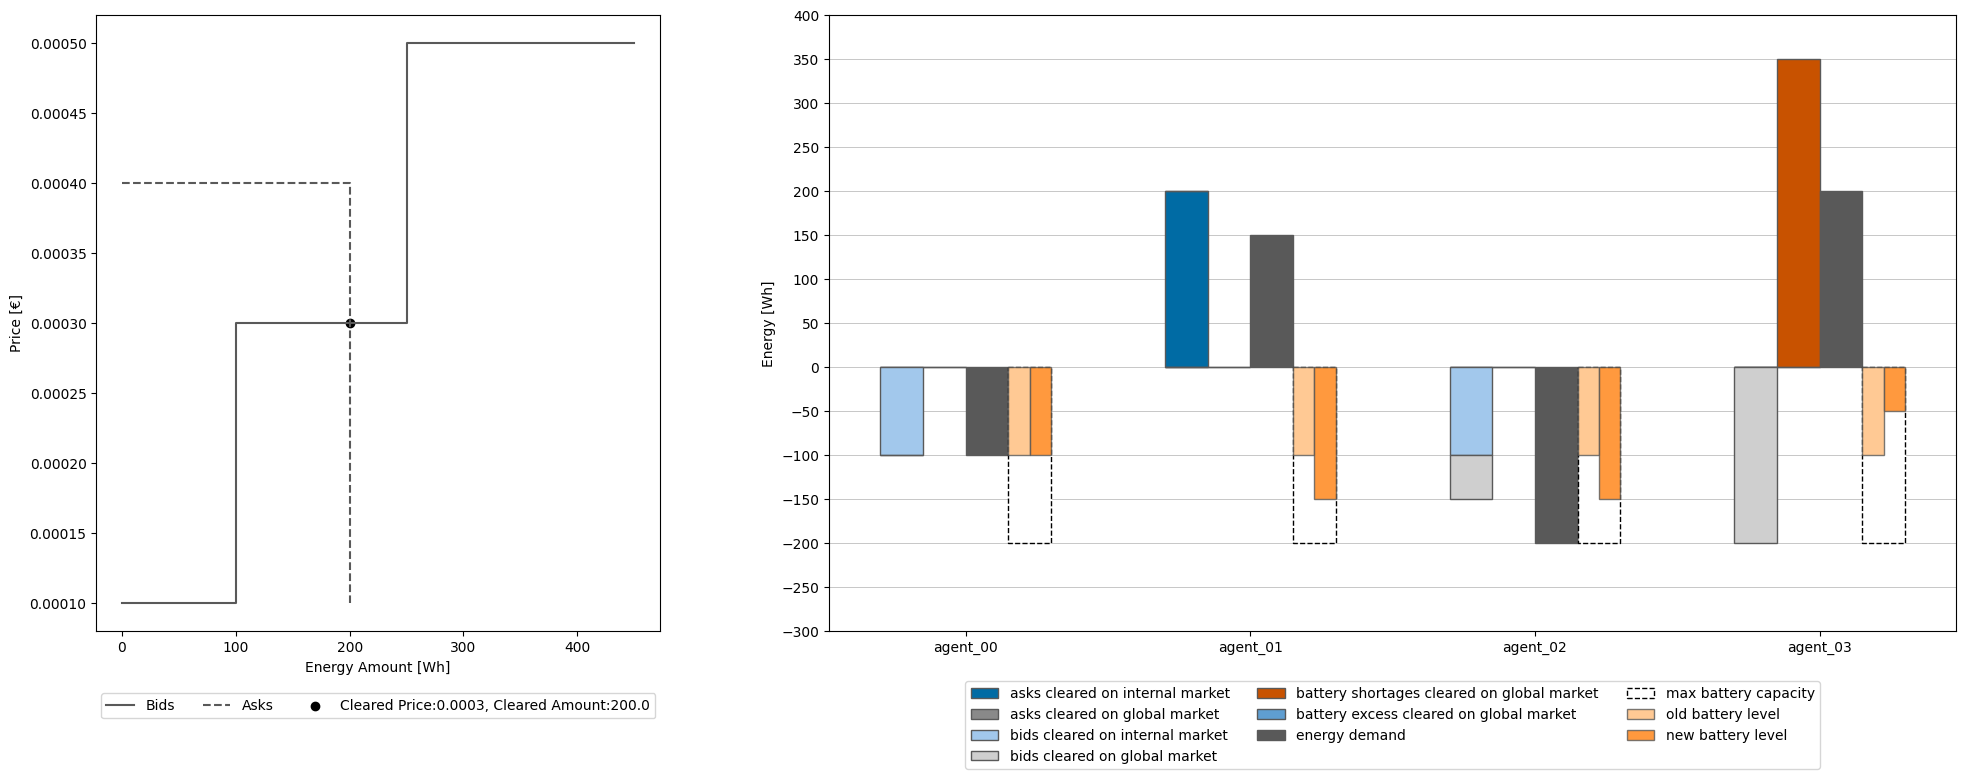

In [10]:
offers = ledger.create_empty_auction(4)


agents = ("agent_00","agent_01","agent_02","agent_03",)
raw_offers = jnp.array([
            [0,0.0001,-100],
            [1,0.0004,200],
            [2,0.0003,-150],
            [3,0.0005,-200]
])

energy_demand = {
    "agent_00":jnp.array([-100]),
    "agent_01":jnp.array([150]),
    "agent_02":jnp.array([-200]),
    "agent_03":jnp.array([200])
}
max_energy_production_Wh = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
battery_level = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
max_battery_capacity_Wh = {
    "agent_00":jnp.array([200]),
    "agent_01":jnp.array([200]),
    "agent_02":jnp.array([200]),
    "agent_03":jnp.array([200])
}

max_battery_peak_capacity_Wh = {
    "agent_00":jnp.array([50]),
    "agent_01":jnp.array([50]),
    "agent_02":jnp.array([50]),
    "agent_03":jnp.array([50])
}


state = EnvironmentState(
    epoch=0,
    timestep=0,
    time_of_use_price=jnp.array([0.0005]),
    feed_in_price=jnp.array([0.0006]),
    day_ahead_window=jnp.array([0,0]),
    energy_demand=energy_demand,
    max_energy_production_Wh= max_energy_production_Wh,
    battery_level=battery_level,
    max_battery_capacity_Wh=max_battery_capacity_Wh,
    max_battery_peak_Wh=max_battery_peak_capacity_Wh
)

global_market = globalmarket.GlobalMarket(
                    nbr_of_samples= state.timestep+1,
                    feed_in_cte_cost=0,
                    feed_in_cte_Wh_cost=0.0000,
                    feed_in_perc_Wh_cost=0,
                    time_of_use_cte_cost=0,
                    time_of_use_cte_Wh_cost=0.0002,
                    time_of_use_perc_Wh_cost=0,
                    years=jnp.full(state.timestep+1,2024),
                    months=jnp.full(state.timestep+1,1),
                    weeknumbers=jnp.full(state.timestep+1,1),
                    weekdays=jnp.full(state.timestep+1,1),
                    hours=jnp.full(state.timestep+1,1),
                    day_ahead_prices_Wh=jnp.full(state.timestep+1,0.0005),
                    day_ahead_window_size=12,
                    day_ahead_window_hour_trigger= 11  
)
_ = plot_auction_and_balance(raw_offers,global_market,state,agents,filename=os.path.join(folder,"cleared_market_and_balance_example.pdf"))

## Transformer plots
---


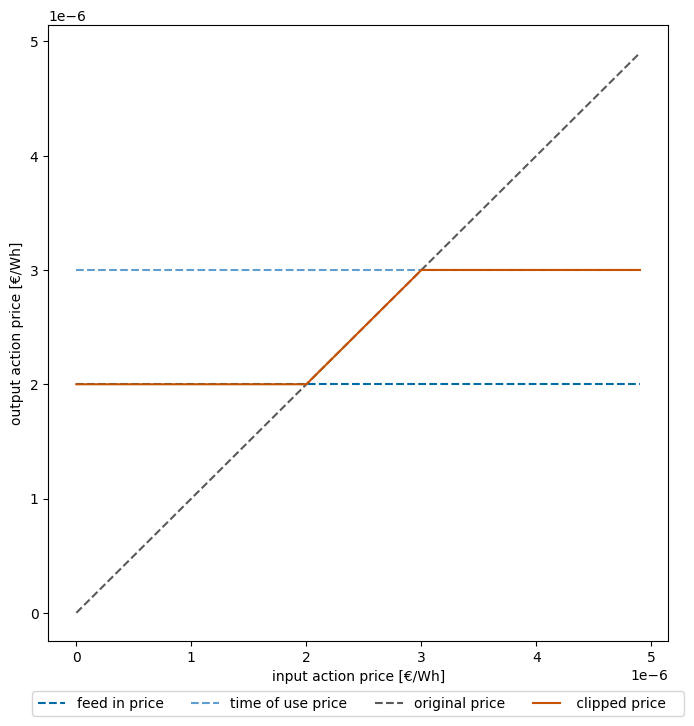

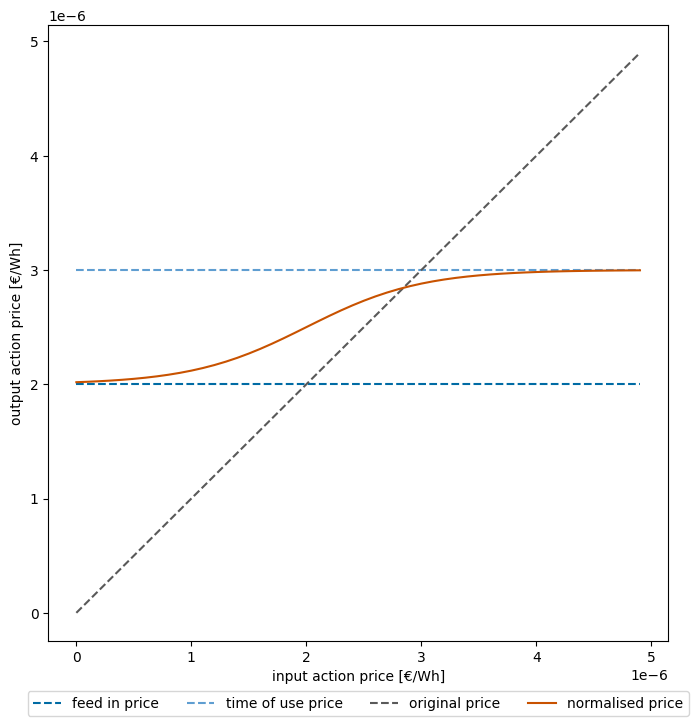

In [4]:
max_val = jnp.array(0.000003)
min_val = jnp.array(0.000002)

range_max = 0.000005
nbr_of_points = 50


x = jnp.arange(0,range_max,range_max/nbr_of_points)
y = th.clip_action_price_to_globalmarket(max_val,min_val,x)

fig,ax = plt.subplots(figsize=(8,8))
min_full = jnp.full(nbr_of_points,min_val)
max_full = jnp.full(nbr_of_points,max_val)

ax.plot(x,min_full,color = CB_COLORS['dark_blue'],linestyle= 'dashed',label="feed in price")
ax.plot(x,max_full,color = CB_COLORS['blue'],linestyle= 'dashed',label="time of use price")
ax.plot(x,x,color =CB_COLORS['black'],linestyle= 'dashed', label="original price")
ax.plot(x,y,color =CB_COLORS['red'],label=" clipped price   ")
#ax.set_yticks(x)
ax.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, -0.07),)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_xlabel("input action price [€/Wh]")
ax.set_ylabel('output action price [€/Wh]')
plt.savefig(os.path.join(folder,"price_clipping.pdf"),format="pdf",bbox_inches='tight')


y = th.tanh_normalise_action_price_to_globalmarket(max_val,min_val,x)

fig,ax = plt.subplots(figsize=(8,8))

ax.plot(x,min_full,color = CB_COLORS['dark_blue'],linestyle= 'dashed',label="feed in price")
ax.plot(x,max_full,color = CB_COLORS['blue'],linestyle= 'dashed',label="time of use price")
ax.plot(x,x,color =CB_COLORS['black'],linestyle= 'dashed', label="original price")
ax.plot(x,y,color =CB_COLORS['red'],label="normalised price")
ax.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, -0.07),)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_xlabel("input action price [€/Wh]")
ax.set_ylabel('output action price [€/Wh]')
plt.savefig(os.path.join(folder,"price_tanh_normalising.pdf"),format="pdf",bbox_inches='tight')

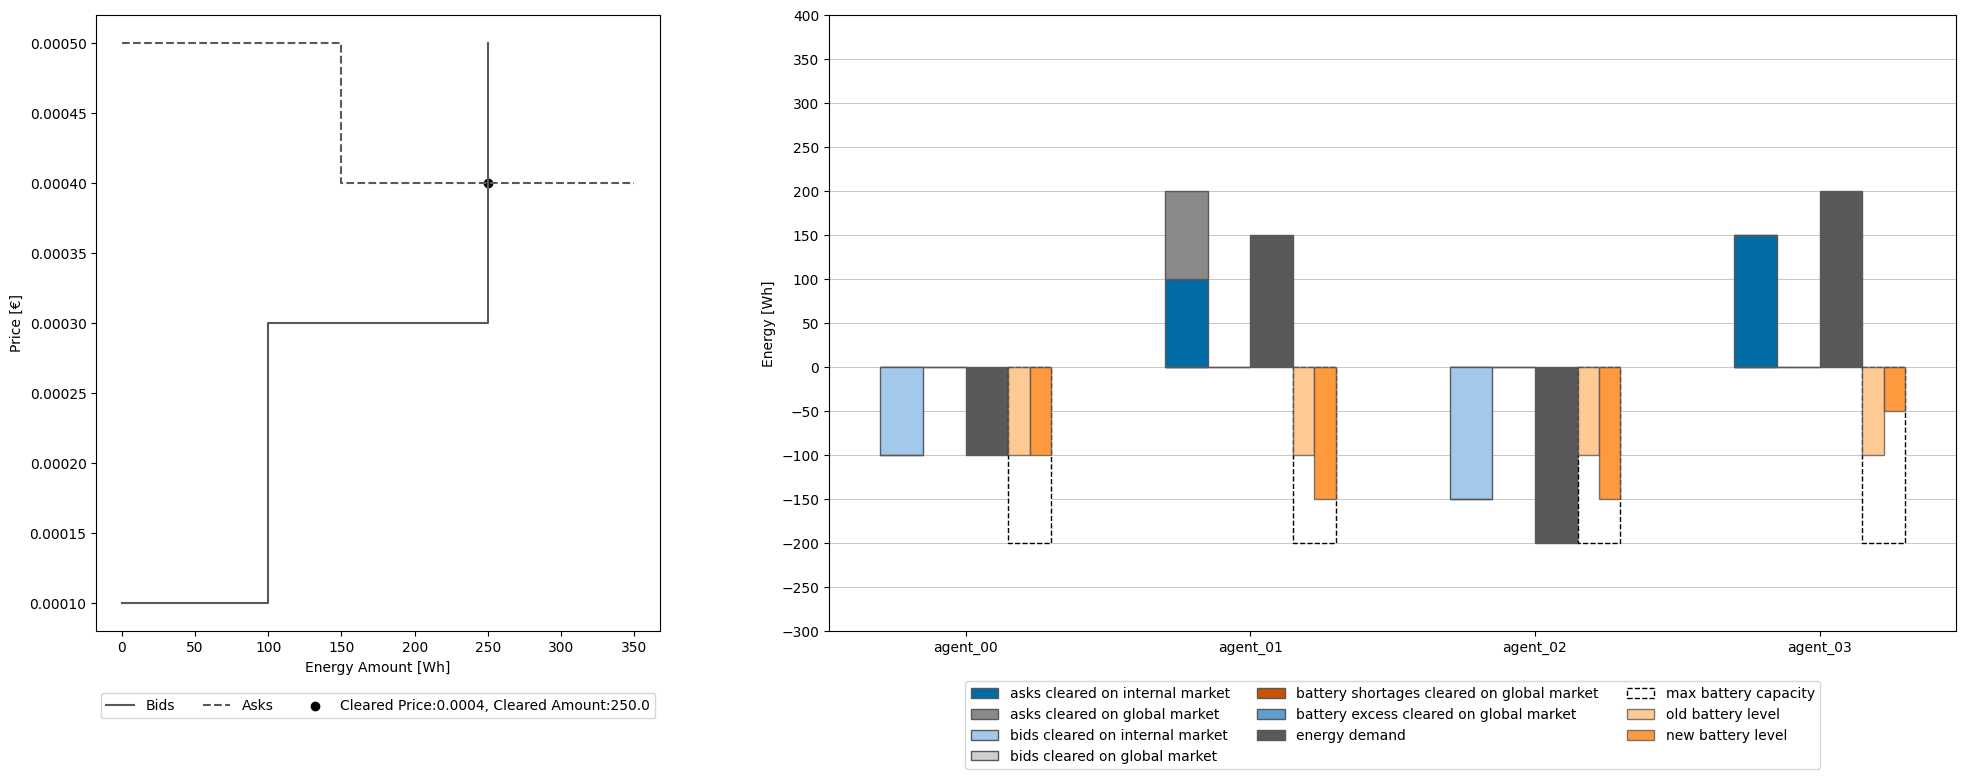

In [31]:
offers = ledger.create_empty_auction(4)


agents = ("agent_00","agent_01","agent_02","agent_03",)
raw_offers = jnp.array([
            [0,0.0001,-100],
            [1,0.0004,200],
            [2,0.0003,-150],
            [3,0.0005,-200]
])

energy_demand = {
    "agent_00":jnp.array([-100]),
    "agent_01":jnp.array([150]),
    "agent_02":jnp.array([-200]),
    "agent_03":jnp.array([200])
}
max_energy_production_Wh = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
battery_level = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
max_battery_capacity_Wh = {
    "agent_00":jnp.array([200]),
    "agent_01":jnp.array([200]),
    "agent_02":jnp.array([200]),
    "agent_03":jnp.array([200])
}

max_battery_peak_capacity_Wh = {
    "agent_00":jnp.array([50]),
    "agent_01":jnp.array([50]),
    "agent_02":jnp.array([50]),
    "agent_03":jnp.array([50])
}


clipped_amounts = jnp.array([th.clip_action_amount_to_battery(50,200,battery_level[agent],raw_offers[i,3],energy_demand[agent]) for i, agent in enumerate(agents)])

clipped_offers = raw_offers.at[:,2].set(clipped_amounts.T.flatten())                       
state = EnvironmentState(
    epoch=0,
    timestep=0,
    time_of_use_price=jnp.array([0.0005]),
    feed_in_price=jnp.array([0.0006]),
    day_ahead_window=jnp.array([0,0]),
    energy_demand=energy_demand,
    max_energy_production_Wh= max_energy_production_Wh,
    battery_level=battery_level,
    max_battery_capacity_Wh=max_battery_capacity_Wh,
    max_battery_peak_Wh=max_battery_peak_capacity_Wh
)

global_market = globalmarket.GlobalMarket(
                    nbr_of_samples= state.timestep+1,
                    feed_in_cte_cost=0,
                    feed_in_cte_Wh_cost=0.0000,
                    feed_in_perc_Wh_cost=0,
                    time_of_use_cte_cost=0,
                    time_of_use_cte_Wh_cost=0.0002,
                    time_of_use_perc_Wh_cost=0,
                    years=jnp.full(state.timestep+1,2024),
                    months=jnp.full(state.timestep+1,1),
                    weeknumbers=jnp.full(state.timestep+1,1),
                    weekdays=jnp.full(state.timestep+1,1),
                    hours=jnp.full(state.timestep+1,1),
                    day_ahead_prices_Wh=jnp.full(state.timestep+1,0.0005),
                    day_ahead_window_size=12,
                    day_ahead_window_hour_trigger= 11  
)
_ = plot_auction_and_balance(clipped_offers,global_market,state,agents,filename=os.path.join(folder,"cleared_market_and_balance_example_with_amount_clipping.pdf"))

In [17]:
def plot_auction(
        raw_offers:jax.Array,
        global_market:globalmarket.GlobalMarket,
        state:EnvironmentState,
        agents:Tuple[str,...],
        filename:str="") -> doubleAuction.ClearedMarket:
    

    offers = ledger.add_all_offers(raw_offers)
    nbr_of_agents = len(agents)
    ordered_cumul_offers = doubleAuction._create_ordered_offers(offers)
    cleared_market = doubleAuction.clear_market(offers,nbr_of_agents)
        
    cleared_market = globalmarket.clear_non_cleared_offers_on_global_market(global_market,state.timestep,cleared_market)
    battery_excess = _calculate_battery_level_and_excesses(state,agents,raw_offers[:,ledger.OfferElemIndex.AMOUNT])
    cleared_market = globalmarket.add_battery_level_out_of_bounds(
                                        global_market,state.timestep,
                                        cleared_market,
                                        jnp.arange(len(agents)),
                                        battery_excess.shortage,
                                        battery_excess.overflow)

    asks = ordered_cumul_offers.asks
    bids = ordered_cumul_offers.bids
    final_price = cleared_market.price
    final_amount = cleared_market.amount
    
    ask_cum_amounts = jnp.cumsum(asks[:, ledger.OfferElemIndex.AMOUNT]) # cumulate amounts to create plot x values
    ask_prices = asks[:,ledger.OfferElemIndex.PRICE]
    bid_cum_amounts = jnp.cumsum(bids[:, ledger.OfferElemIndex.AMOUNT]) # cumulate amounts to create plot x values
    bid_prices = bids[:,ledger.OfferElemIndex.PRICE] 

    max_point_on_price_axis = jnp.max(jnp.append(ask_prices,bid_prices[~jnp.isinf(bid_prices)]))
    min_point_on_price_axis = jnp.min(jnp.append(ask_prices[~jnp.isneginf(ask_prices)],bid_prices))
    
    # add first point of ask plot
    ask_cum_amounts = jnp.append(0,ask_cum_amounts)
    ask_prices = jnp.append(ask_prices[0],ask_prices)

    # add first point of bid plot
    bid_cum_amounts = jnp.append(0,bid_cum_amounts)  
    bid_prices = jnp.append(bid_prices[0],bid_prices)
    
    # replace inf values and add last point of bid plot or ask plot ependant on which is shorter
    if ask_cum_amounts[-1] > bid_cum_amounts[-1]:
        bid_cum_amounts = jnp.append(bid_cum_amounts,bid_cum_amounts[-1])
        bid_prices = jnp.where(jnp.isinf(bid_prices), max_point_on_price_axis, bid_prices)
        bid_prices = jnp.append(bid_prices,max_point_on_price_axis)

    if ask_cum_amounts[-1] <= bid_cum_amounts[-1]:
        ask_cum_amounts = jnp.append(ask_cum_amounts,ask_cum_amounts[-1])
        ask_prices = jnp.where(jnp.isneginf(ask_prices), min_point_on_price_axis, ask_prices)
        ask_prices = jnp.append(ask_prices,min_point_on_price_axis)

    
    fig, ax1 = plt.subplots(figsize=(8, 8))
    ax1.step(bid_cum_amounts,bid_prices,where="pre",label="Bids",color=CB_COLORS["black"])
    ax1.step(ask_cum_amounts,ask_prices,where="pre",label="Asks",linestyle="--",color=CB_COLORS["black"])
    if final_amount > 0:
        ax1.scatter(final_amount,final_price,label=f'Cleared Price:{round(final_price.item(),5)}, Cleared Amount:{final_amount}',color="black")
    ax1.set_xlabel("Energy Amount [Wh]")
    ax1.set_ylabel('Price [€]')
    ax1.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.09),)

    if filename:
        plt.savefig(filename,format="pdf",bbox_inches='tight')
    else:
        plt.show()
    return cleared_market

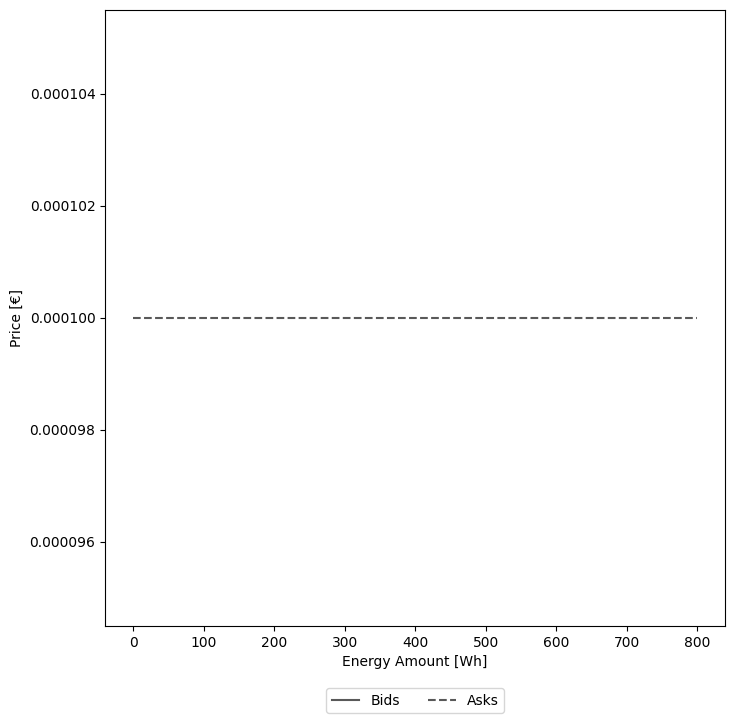

In [24]:
offers = ledger.create_empty_auction(4)


agents = ("agent_00","agent_01","agent_02","agent_03",)
raw_offers = jnp.array([
            [0,0.0001,200],
            [1,0.0001,200],
            [2,0.0001,200],
            [3,0.0001,200]
])

energy_demand = {
    "agent_00":jnp.array([-100]),
    "agent_01":jnp.array([150]),
    "agent_02":jnp.array([-200]),
    "agent_03":jnp.array([200])
}
max_energy_production_Wh = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
battery_level = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
max_battery_capacity_Wh = {
    "agent_00":jnp.array([200]),
    "agent_01":jnp.array([200]),
    "agent_02":jnp.array([200]),
    "agent_03":jnp.array([200])
}

max_battery_peak_capacity_Wh = {
    "agent_00":jnp.array([50]),
    "agent_01":jnp.array([50]),
    "agent_02":jnp.array([50]),
    "agent_03":jnp.array([50])
}


#clipped_amounts = jnp.array([th.clip_action_amount_to_battery(50,200,battery_level[agent],raw_offers[i,3],energy_demand[agent]) for i, agent in enumerate(agents)])

#clipped_offers = raw_offers.at[:,2].set(clipped_amounts.T.flatten())                       
state = EnvironmentState(
    epoch=0,
    timestep=0,
    time_of_use_price=jnp.array([0.0005]),
    feed_in_price=jnp.array([0.0006]),
    day_ahead_window=jnp.array([0,0]),
    energy_demand=energy_demand,
    max_energy_production_Wh= max_energy_production_Wh,
    battery_level=battery_level,
    max_battery_capacity_Wh=max_battery_capacity_Wh,
    max_battery_peak_Wh=max_battery_peak_capacity_Wh
)

global_market = globalmarket.GlobalMarket(
                    nbr_of_samples= state.timestep+1,
                    feed_in_cte_cost=0,
                    feed_in_cte_Wh_cost=0.0000,
                    feed_in_perc_Wh_cost=0,
                    time_of_use_cte_cost=0,
                    time_of_use_cte_Wh_cost=0.0002,
                    time_of_use_perc_Wh_cost=0,
                    years=jnp.full(state.timestep+1,2024),
                    months=jnp.full(state.timestep+1,1),
                    weeknumbers=jnp.full(state.timestep+1,1),
                    weekdays=jnp.full(state.timestep+1,1),
                    hours=jnp.full(state.timestep+1,1),
                    day_ahead_prices_Wh=jnp.full(state.timestep+1,0.0005),
                    day_ahead_window_size=12,
                    day_ahead_window_hour_trigger= 11  
)
_ = plot_auction(raw_offers,global_market,state,agents,filename=os.path.join(folder,"fully_cleared_market.pdf"))

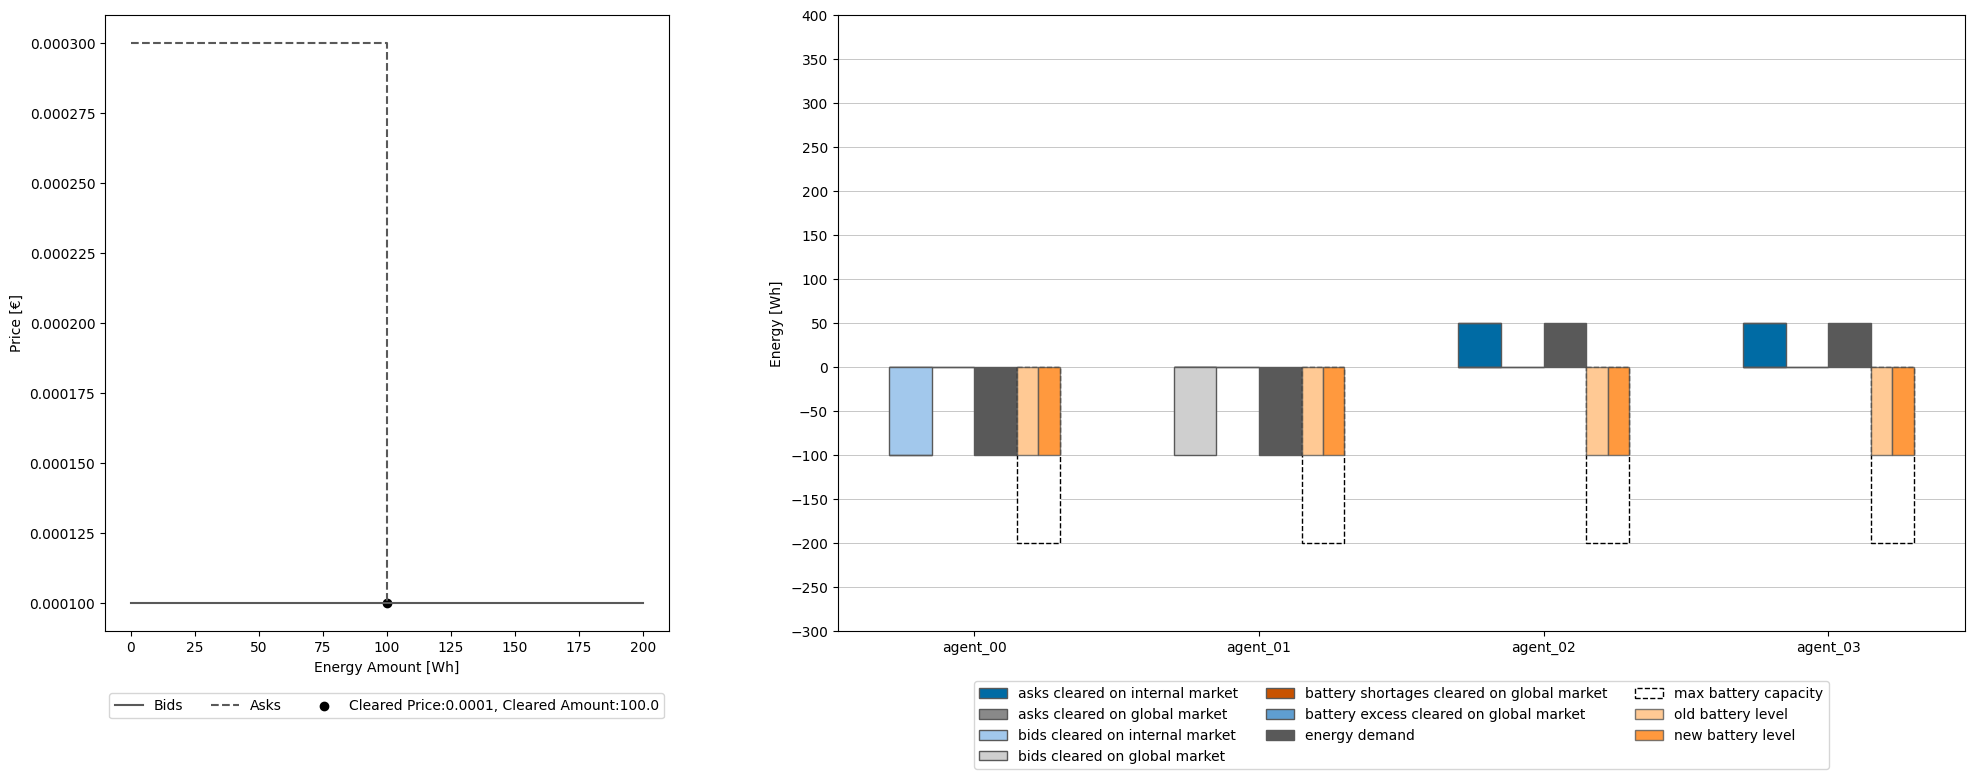

In [33]:
offers = ledger.create_empty_auction(4)


agents = ("agent_00","agent_01","agent_02","agent_03",)
raw_offers = jnp.array([
            [0,0.0001,-100],
            [1,0.0001,-100],
            [2,0.0003,50],
            [3,0.0003,50]
])

energy_demand = {
    "agent_00":jnp.array([-100]),
    "agent_01":jnp.array([-100]),
    "agent_02":jnp.array([50]),
    "agent_03":jnp.array([50])
}
max_energy_production_Wh = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
battery_level = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
max_battery_capacity_Wh = {
    "agent_00":jnp.array([200]),
    "agent_01":jnp.array([200]),
    "agent_02":jnp.array([200]),
    "agent_03":jnp.array([200])
}

max_battery_peak_capacity_Wh = {
    "agent_00":jnp.array([50]),
    "agent_01":jnp.array([50]),
    "agent_02":jnp.array([50]),
    "agent_03":jnp.array([50])
}


clipped_amounts = jnp.array([th.clip_action_amount_to_battery(50,200,battery_level[agent],raw_offers[i,3],energy_demand[agent]) for i, agent in enumerate(agents)])

clipped_offers = raw_offers.at[:,2].set(clipped_amounts.T.flatten())                       
state = EnvironmentState(
    epoch=0,
    timestep=0,
    time_of_use_price=jnp.array([0.0005]),
    feed_in_price=jnp.array([0.0006]),
    day_ahead_window=jnp.array([0,0]),
    energy_demand=energy_demand,
    max_energy_production_Wh= max_energy_production_Wh,
    battery_level=battery_level,
    max_battery_capacity_Wh=max_battery_capacity_Wh,
    max_battery_peak_Wh=max_battery_peak_capacity_Wh
)

global_market = globalmarket.GlobalMarket(
                    nbr_of_samples= state.timestep+1,
                    feed_in_cte_cost=0,
                    feed_in_cte_Wh_cost=0.0000,
                    feed_in_perc_Wh_cost=0,
                    time_of_use_cte_cost=0,
                    time_of_use_cte_Wh_cost=0.0002,
                    time_of_use_perc_Wh_cost=0,
                    years=jnp.full(state.timestep+1,2024),
                    months=jnp.full(state.timestep+1,1),
                    weeknumbers=jnp.full(state.timestep+1,1),
                    weekdays=jnp.full(state.timestep+1,1),
                    hours=jnp.full(state.timestep+1,1),
                    day_ahead_prices_Wh=jnp.full(state.timestep+1,0.0005),
                    day_ahead_window_size=12,
                    day_ahead_window_hour_trigger= 11  
)
_ = plot_auction_and_balance(clipped_offers,global_market,state,agents,filename=os.path.join(folder,"cleared_market_and_balance_example_with_amount_discrepancy_1.pdf"))

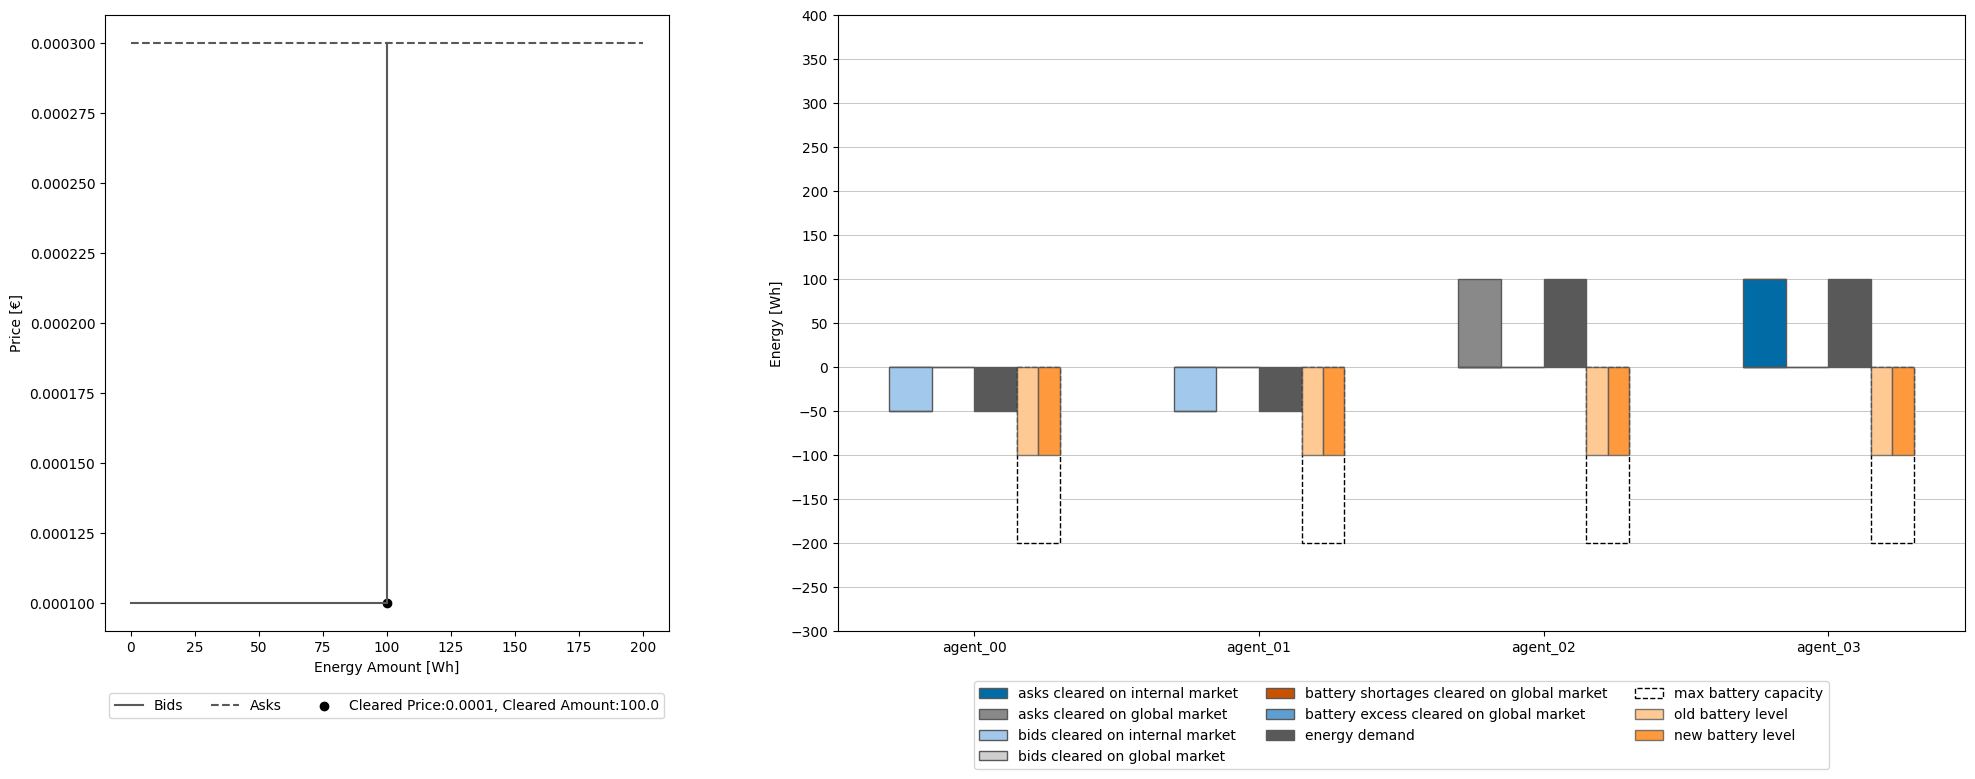

In [34]:
offers = ledger.create_empty_auction(4)


agents = ("agent_00","agent_01","agent_02","agent_03",)
raw_offers = jnp.array([
            [0,0.0001,-50],
            [1,0.0001,-50],
            [2,0.0003,100],
            [3,0.0003,100]
])

energy_demand = {
    "agent_00":jnp.array([-50]),
    "agent_01":jnp.array([-50]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
max_energy_production_Wh = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
battery_level = {
    "agent_00":jnp.array([100]),
    "agent_01":jnp.array([100]),
    "agent_02":jnp.array([100]),
    "agent_03":jnp.array([100])
}
max_battery_capacity_Wh = {
    "agent_00":jnp.array([200]),
    "agent_01":jnp.array([200]),
    "agent_02":jnp.array([200]),
    "agent_03":jnp.array([200])
}

max_battery_peak_capacity_Wh = {
    "agent_00":jnp.array([50]),
    "agent_01":jnp.array([50]),
    "agent_02":jnp.array([50]),
    "agent_03":jnp.array([50])
}


clipped_amounts = jnp.array([th.clip_action_amount_to_battery(50,200,battery_level[agent],raw_offers[i,3],energy_demand[agent]) for i, agent in enumerate(agents)])

clipped_offers = raw_offers.at[:,2].set(clipped_amounts.T.flatten())                       
state = EnvironmentState(
    epoch=0,
    timestep=0,
    time_of_use_price=jnp.array([0.0005]),
    feed_in_price=jnp.array([0.0006]),
    day_ahead_window=jnp.array([0,0]),
    energy_demand=energy_demand,
    max_energy_production_Wh= max_energy_production_Wh,
    battery_level=battery_level,
    max_battery_capacity_Wh=max_battery_capacity_Wh,
    max_battery_peak_Wh=max_battery_peak_capacity_Wh
)

global_market = globalmarket.GlobalMarket(
                    nbr_of_samples= state.timestep+1,
                    feed_in_cte_cost=0,
                    feed_in_cte_Wh_cost=0.0000,
                    feed_in_perc_Wh_cost=0,
                    time_of_use_cte_cost=0,
                    time_of_use_cte_Wh_cost=0.0002,
                    time_of_use_perc_Wh_cost=0,
                    years=jnp.full(state.timestep+1,2024),
                    months=jnp.full(state.timestep+1,1),
                    weeknumbers=jnp.full(state.timestep+1,1),
                    weekdays=jnp.full(state.timestep+1,1),
                    hours=jnp.full(state.timestep+1,1),
                    day_ahead_prices_Wh=jnp.full(state.timestep+1,0.0005),
                    day_ahead_window_size=12,
                    day_ahead_window_hour_trigger= 11  
)
_ = plot_auction_and_balance(clipped_offers,global_market,state,agents,filename=os.path.join(folder,"cleared_market_and_balance_example_with_amount_discrepancy_2.pdf"))